# The problem with 3 way oscillation
We’ve already discussed and demonstrated oscillation behaviors. 2 scenarios we showed were a simple 2-way full-cluster oscillation:

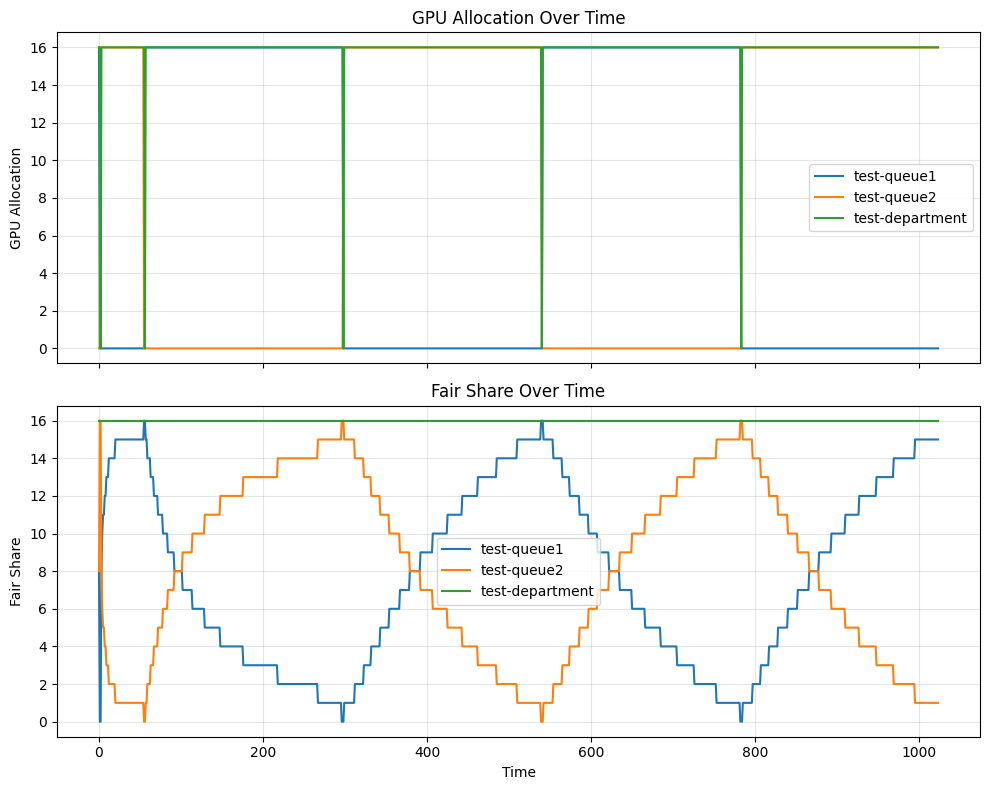

In [20]:
plot_simulation_results("2-way-oscillaiton.csv")

And 2-way, 50% + 1 cluster oscillation (2 queues that require just a bit more than half the cluster), which are much more frequent (unless controlled with relcaim ratio or min runtime):

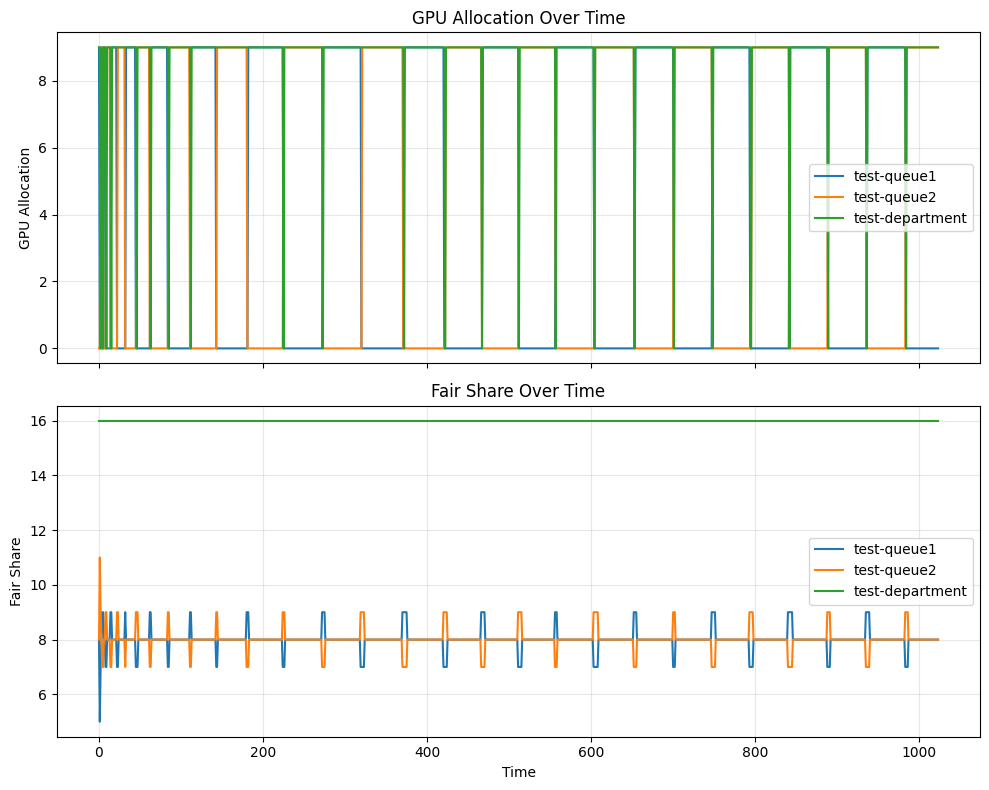

In [21]:
plot_simulation_results("50-plus-1-oscillation.csv")

But when I tried a similar case, but with 3 queues, I got the following result:

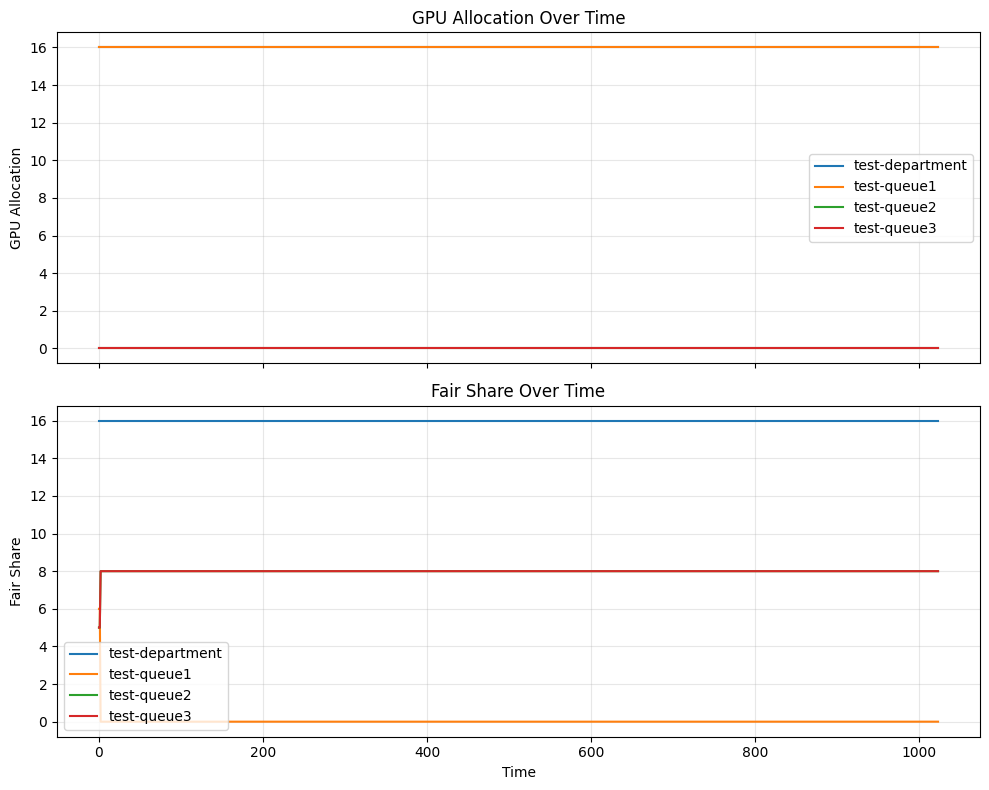

In [22]:
plot_simulation_results("3-way-oscillation.csv")

Queue 1 got to allocate all GPUs first, and it’s fair share quickly went to 0. But, the other two queues are symmetrical, the fair share in the cluster is split evenly between them. This means that they both get 8 as their fair share. Since they both request 16 GPUs, none of them gets to reclaim the resources - their jobs are filtered right away:

```Go
func (r *Reclaimable) CanReclaimResources(
    queues map[common_info.QueueID]*rs.QueueAttributes,
    reclaimer *ReclaimerInfo,
) bool {
    reclaimerQueue := queues[reclaimer.Queue]
    requestedResources := utils.QuantifyResource(reclaimer.RequiredResources)

    allocatedResources := reclaimerQueue.GetAllocatedShare()
    allocatedResources.Add(requestedResources)
    if !allocatedResources.LessEqual(reclaimerQueue.GetFairShare()) {
        return false
    }

    ...

    return true
}

```
`pkg/scheduler/plugins/proportion/reclaimable/reclaimable.go`